In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import psycopg2
import getpass
from datetime import timedelta

In [5]:
# Uncomment next line for first run. Then recomment
sys.path.append('/home/mike/dsi/capstones/climbing_gym_checkins_eda')
from src.paths import data_path, prj_path
from src.sql_exec import SqlExec
print(sys.path[-3:-1])

['/home/mike/dsi/capstones/public-repos/climbing_gym_checkins', '/home/mike/dsi/public-repos/climbing_gym_checkins']


In [6]:
g_sql = SqlExec('gol')
w_df = g_sql.weather(select_all=True)

In [7]:
# Plotting settings
plt.style.use('ggplot')

# Weather Data

In order to compare the gym check-in data with the weather, I need to have historical data for the area around the gyms that has been recorded hourly. There is a National Renewable Energy Laboratory (NREL) Solar Radiation Research Laboratory (SRRL) in Golden. The facility has been collecting and storing hourly weather data since 1981. This data is all available online which can be downloaded as csv files. The station is about 2 miles from the Golden gym and about 11 miles from the Englewood gym. Most of the sensors that are available are for solar data but there is a multitude of sensors that are specifically weather that seems pertinent to whether a person would decide to go to the gym.

The columns of the raw data are: <br>

|COLUMN|DESCRIPTION|LINK|
|---|---|---|
|`DATE (MM/DD/YYYY)`|The day of the observation in MST|
|`HOUR-MST`|The hour of the observation in MST|
|`Avg Deck Dry Bulb Temp [deg C]`|The average hourly dry bulb temperature taken at the deck (near the ground) in degrees Celsius|
|`Avg Total Cloud Cover [%]`|The average hourly cloud cover including semi-transparent clouds|
|`Avg Opaque Cloud Cover [%]`|The average hourly cloud cover of only opaque clouds|
|`Avg Avg Wind Speed @ 6ft [m/s]`|The average hourly wind speed taken at 6ft in m/s|
|`Avg Avg Wind Speed @ 19ft [m/s]`|The average hourly wind speed taken at 19ft in m/s|
|`Avg Precipitation [mm]`|The average hourly precipitation in mm|
|`Avg Snow Depth [cm]`|The average snow depth in cm|

In [8]:
df_raw_weather = pd.read_csv('/home/mike/dsi/capstones/data_climb/weather/processed/nrl_weather.csv')

In [9]:
df_raw_weather

,DATE (MM/DD/YYYY),HOUR-MST,Avg Deck Dry Bulb Temp [deg C],Avg Total Cloud Cover [%],Avg Opaque Cloud Cover [%],Avg Avg Wind Speed @ 6ft [m/s],Avg Avg Wind Speed @ 19ft [m/s],Avg Precipitation [mm],Avg Snow Depth [cm],Avg Snow Depth Quality
0,7/31/2013,1,20.4477,-1.0,-1.0,1.2930,1.8775,0.0,-0.3844,193.9567
1,7/31/2013,2,19.7425,-1.0,-1.0,2.6637,3.5895,0.0,-0.0902,193.6517
2,7/31/2013,3,18.1818,-1.0,-1.0,1.7269,2.7045,0.0,-0.0329,193.0250
3,7/31/2013,4,17.1130,-1.0,-1.0,0.7916,1.6774,0.0,-0.0448,193.9417
4,7/31/2013,5,16.5497,-1.0,-1.0,0.9635,1.2428,0.0,-0.0770,193.9117
...,...,...,...,...,...,...,...,...,...,...
55935,12/17/2019,19,1.3526,-1.0,-1.0,0.3127,0.2760,0.0,0.1591,194.0467
55936,12/17/2019,20,1.4430,-1.0,-1.0,0.6254,0.9133,0.0,0.2061,194.0517
55937,12/17/2019,21,2.0754,-1.0,-1.0,1.3962,1.7191,0.0,0.1834,194.0450
55938,12/17/2019,22,2.9186,-1.0,-1.0,2.6236,3.2697,0.0,0.1955,194.0667


In [10]:
df_raw_weather.describe()

,HOUR-MST,Avg Deck Dry Bulb Temp [deg C],Avg Total Cloud Cover [%],Avg Opaque Cloud Cover [%],Avg Avg Wind Speed @ 6ft [m/s],Avg Avg Wind Speed @ 19ft [m/s],Avg Precipitation [mm],Avg Snow Depth [cm],Avg Snow Depth Quality
count,55940.000000,55940.000000,55940.000000,55940.000000,55940.000000,55940.000000,55940.000000,55940.000000,55940.000000
mean,11.500822,11.204114,-125.085589,-131.527174,1.974953,2.422700,0.000946,-757.339481,-651.681750
std,6.921813,10.362750,3826.811381,3826.501804,1.354723,1.796940,0.008558,8673.048758,8682.821924
min,0.000000,-24.434500,-99999.000000,-99999.000000,0.000000,0.000000,0.000000,-99999.000000,-99999.000000
25%,6.000000,3.975775,-1.000000,-1.000000,1.092175,1.223575,0.000000,-0.238125,0.163075
50%,12.000000,11.694150,0.100000,0.000000,1.765900,2.005650,0.000000,0.035900,192.720850
75%,18.000000,19.088350,32.483300,17.804175,2.531150,3.158125,0.000000,0.349925,194.255000
max,23.000000,36.627700,99.950000,97.983300,16.268300,18.890700,0.533400,97.500000,403.190000


## Temperature

Air temperature seems like one of the most important weather features that will affect climbing gym check-ins. From my experience most climbers prefer to climb in temperatures between 50 annd 80 degrees F. Performance focused climbers tend to climb when it is colder and may climb outside below 50 degrees for optimal performance but is generally a less comfortable overall experience. More recreational climbers tend to want to climb outside when it is warmer as the experience tends to be more comfortable and enjoyable but makes more difficult climbs even more challenging or impossible.

The SRRL facility has different temperature measurements including dry and wet bulb temperatures and wind chill temperatures. I think the most people use the weather forecast to make decisions and the most common temperature measurement used is the dry bulb temperature. That is the measurement I selected for my temperature feature.

The raw data is in Celsius but looks good other than that. I converted it to Fahrenheit.

/home/mike/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


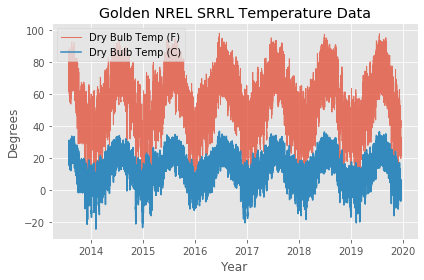

,dry_bulb_temp_c,temp_f
count,55934.000000,55934.000000
mean,11.205034,52.169061
std,10.362789,18.653019
min,-24.434500,-11.982100
25%,3.977525,39.159545
50%,11.695050,53.051090
75%,19.088800,66.359840
max,36.627700,97.929860


In [11]:
# plot and describe temperature data
fig, ax = plt.subplots()

ax.plot(w_df.temp_f, label='Dry Bulb Temp (F)', linewidth=1, alpha=0.75)
ax.plot(w_df.dry_bulb_temp_c, label='Dry Bulb Temp (C)')
ax.set_ylabel('Degrees')
ax.set_xlabel('Year')
ax.legend(loc='upper left')
ax.set_title('Golden NREL SRRL Temperature Data')

plt.tight_layout()
plt.show()

w_df[['dry_bulb_temp_c', 'temp_f']].describe()

## Cloud Cover

I downloaded 2 different columns for cloud cover `Avg Total Cloud Cover [%]` and `Avg Opaque Cloud Cover [%]`. Cloud cover is measured with the [SRRL TSI-880 Sky Imager Gallery](https://midcdmz.nrel.gov/apps/imagergallery.pl?SRRL). This instrument captures an all sky image, analyzes it and computes the percentage of *Opaque Clouds* coverage and *Thin Clouds* coverage. <br>
<table style="width:100%">
    <tr>
        <th>Image from TSI-880 on a clear day</th>
        <th>Image from TSI-880 on a cloudy day</th>
    </tr>
    <tr>
        <td style="text-align: center;">
            <img src="../images/20191114_clear_raw.png" width="200" height="400" /><img src="../images/20191114_clear_calc.png" width="200" height="400" />
        </td>
        <td style="text-align: center;">
            <img src="../images/20190614_cloudy_raw.png" width="200" height="400" /><img src="../images/20190614_cloudy_calc.png" width="200" height="400" />
        </td>
    </tr>
</table> <br>

The `Avg Total Cloud Cover [%]` is the *Opaque Clouds* + *Thin Clouds* while the `Avg Opaque Cloud Cover [%]` is just the *Opaque Clouds* coverage. The Pearson correlation between the columns is close to 1. For simplicity, I decided to use the `Avg Opaque Cloud Cover [%]` because I felt opaque clouds have more of an effect on people's tendency to want to be outside or not.

As you can see below there are some extreme negative values. This is due to the SRRL data using -99999 as a NULL value.

In [12]:
w_df[['opaque_cloud_cover', 'total_cloud_cover']].corr()

,opaque_cloud_cover,total_cloud_cover
opaque_cloud_cover,1.000000,0.999997
total_cloud_cover,0.999997,1.000000


In [13]:
# describe raw opaque cloud cover data
w_df.opaque_cloud_cover.describe()

count    55934.000000
mean      -131.541176
std       3826.706796
min     -99999.000000
25%         -1.000000
50%          0.000000
75%         17.816700
max         97.983300
Name: opaque_cloud_cover, dtype: float64

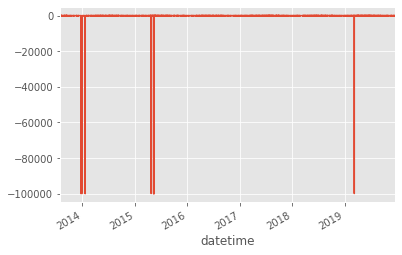

In [14]:
# plot raw opaque cloud cover data
_ = w_df.opaque_cloud_cover.plot()

Removing these null values shows a graph that we would expect. There are still some values that are -1.

In [15]:
# describe data with nulls removed
w_df.opaque_cloud_cover[w_df.opaque_cloud_cover != -99999].describe()

count    55852.000000
mean        15.080819
std         25.653555
min         -1.000000
25%         -1.000000
50%          0.033300
75%         17.883300
max         97.983300
Name: opaque_cloud_cover, dtype: float64

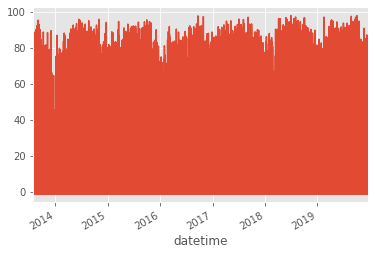

In [16]:
# plot with nulls removed
_ = w_df.opaque_cloud_cover[w_df.opaque_cloud_cover != -99999].plot()

In [17]:
# count -1 values
print(f'Count of -1 values" {(w_df.opaque_cloud_cover == -1).sum()}')

Count of -1 values" 26792


In [18]:
# percentage of -1
print(f'Percentage of values that are -1: {(w_df.opaque_cloud_cover == -1).sum() / w_df.opaque_cloud_cover.count():.2f}')

Percentage of values that are -1: 0.48


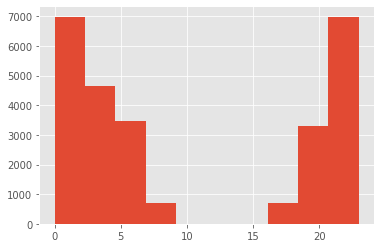

In [19]:
# histogram of hours that have cloud cover of -1
_ = w_df.hour[(w_df.opaque_cloud_cover == -1)].hist()

About half of the values are -1. Looking at the histogram it becomes clear that the values are ssociated with hours of the day that do not have enough daylight for the sensor to read the clouds. Attempting to look up the image for any of those hours results in a *NO PICTURE* message.

To clean the `Avg Opaque Cloud Cover [%]` column, all values less than 0 should be given with NULL values.

## Wind Speed

I downloaded 2 wind speed columns as well. One taken at 6ft and one taken at 19ft. Looking at the graph, the numbers are reasonable and it does not appear that we need to do any complex cleaning. They appear to be correlated so it will simplify the analysis if we can drop one of the columns. In order to see which one to use, lets see if there is a large difference in values.

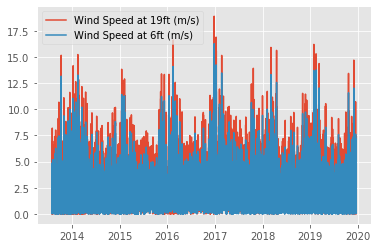

,wind_speed_6ft_m_s,wind_speed_19ft_m_s
wind_speed_6ft_m_s,1.000000,0.916024
wind_speed_19ft_m_s,0.916024,1.000000


In [20]:
fig, ax = plt.subplots()

ax.plot(w_df.wind_speed_19ft_m_s, label='Wind Speed at 19ft (m/s)')
ax.plot(w_df.wind_speed_6ft_m_s, label='Wind Speed at 6ft (m/s)')

plt.legend()
plt.show()

w_df[['wind_speed_6ft_m_s', 'wind_speed_19ft_m_s']].corr()

In [21]:
w_df[['wind_speed_6ft_m_s', 'wind_speed_19ft_m_s']].describe()

,wind_speed_6ft_m_s,wind_speed_19ft_m_s
count,55934.000000,55934.000000
mean,1.974897,2.422599
std,1.354599,1.796813
min,0.000000,0.000000
25%,1.092200,1.223525
50%,1.765900,2.005500
75%,2.531100,3.158100
max,16.268300,18.890700


It is hard to tell from the graph but the Pearson correlation shows a strong correlation between the different wind speeds. The `wind_speed_19ft_m_s` has higher speeds and is slightly more variable. Based on the strong correlation, it will simplify our analysis if we drop one of the columns. I used `wind_speed_6ft_m_s` in my analysis because the choice is fairly arbitrary and I think people are more likely to make decisions on the wind speed they can feel at the ground than 15ft above their heads.

## Precipitation

There are 2 columns available from the SRRL station for precipitation `Avg Precipitation [mm]` and `Precipitation mm (accumulated)`. The accumulated data is not available hourly so only the `Avg Precipitation [mm]` was downloaded. NREL does not provide any documentation on how Avg Precipitation is calculated. I compared it with the minute by minute data from the website and it appears to be an average of the minute by minute data. Hourly average of mm/minute is not a useful unit for analysis. In order to create a useful unit I used the conversion below:

$\large{Hourly Avg Precipitation \: [\frac{mm}{min*hr}] * \frac{1}{25.4} \: [in/mm] * 60 \: [min] = Precipitation \: [in/hr]}$

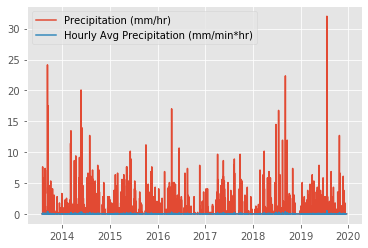

In [22]:
fig, ax = plt.subplots()

ax.plot(w_df.precipitation_mm * 60, label='Precipitation (mm/hr)')
ax.plot(w_df.precipitation_mm, label='Hourly Avg Precipitation (mm/min*hr)')

plt.legend()
plt.show()

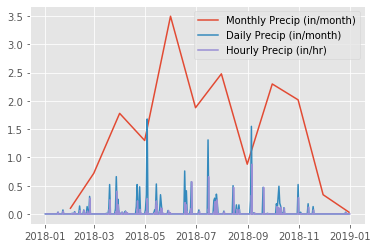

In [23]:
fig, ax = plt.subplots()

ax.plot(w_df.precip_in['2018'].resample('M').sum(), label='Monthly Precip (in/month)')
ax.plot(w_df.precip_in['2018'].resample('D').sum(), label='Daily Precip (in/month)')
ax.plot(w_df.precip_in['2018'], label='Hourly Precip (in/hr)')

plt.legend()
plt.show()

In [24]:
w_df.precip_in.resample('Y').sum()

datetime
2013-12-31 00:00:00-07:00    13.378819
2014-12-31 00:00:00-07:00    21.734646
2015-12-31 00:00:00-07:00    24.584173
2016-12-31 00:00:00-07:00    12.326929
2017-12-31 00:00:00-07:00    18.375827
2018-12-31 00:00:00-07:00    17.324646
2019-12-31 00:00:00-07:00    17.305984
Freq: A-DEC, Name: precip_in, dtype: float64

The precipitaion totals above are consistent with posted annual averages of rainfall for the Golden and Denver area.

## Snow Depth

Snow depth, `Avg Snow Depth [cm]`, is another useful metric for predicting gym check-ins. Most climbers will choose to go to the gym instead of climbing outside if there is snow on the ground. The SRRL station measures snow depth with a [SR50A-L Sonic Distance Sensor](https://www.campbellsci.com/sr50a). This sensor has a reported accuracy of +/- 1cm. The senseor is highly variable and thoughtful data imputation is required for this to be a useful feature in the analysis. An additional measurement `Avg Snow Depth Quality` is used as a quality indicator.

<table>
    <tr>
        <th> Snow Depth Quality </th>
        <th> Description </th>
    </tr>
    <tr>
        <td> 0 </td>
        <td> Not able to read distance </td>
    </tr>
    <tr>
        <td> 162-210 </td>
        <td> Good measurement quality numbers </td>
    </tr>
    <tr>
        <td> 210-300 </td>
        <td> Reduced echo signal strength </td>
    </tr>
    <tr>
        <td> 300-600 </td>
        <td> High measurement uncertainty </td>
    </tr>
</table>

From the SRRL website:

Regarding real time data filtering
> As of 12/13/2007, the datalogger will automatically filter snow depth values, based on quality indicators above. When the quality is outside the "valid" range of 160-250, the previous valid snow depth will be output for up to ~45 minutes, if the quality is still invalid, then the snow depth will become a missing value (-6999).

Regardin inconsistent measuremnets
> Note: In 2011, the SRRL building was expanded to the east, for some reason this expansion included adding new dirt to the area south of the building expansion, as a result this dirt creates snow drifting in the vicinity of the snow depth sensor. On 1/17/2018, the sensor was relocated to a new stand 30 feet west of the radiometer in an effort to find a location that will produce more accurate readings.
    

### Null values

The snow_depth data records NULL values as -99999. Removing these shows extreme negative and positive spikes that need to be smoothed out. It also shows that the `Avg Snow Depth Quality` data is equal to the `Avg Snow Depth [cm]` between the timestamps 2015-01-01 01:00:00-07:00 and 2017-11-30 23:00:00-07:00. These values is invalid and while the snow depth quality does seem to correlate with the extreme variances in the snow depth measurement outside this time it will only complicate the analysis and provide useful information for cleaning the snow depth measurement data. A simple analysis of the the snow depth measurement data can sufficiently find invalid values without the use of the snow depth quality.

In [25]:
w_df.snow_depth_cm.describe()

count    55934.000000
mean      -757.420793
std       8673.510376
min     -99999.000000
25%         -0.238200
50%          0.035900
75%          0.349900
max         97.500000
Name: snow_depth_cm, dtype: float64

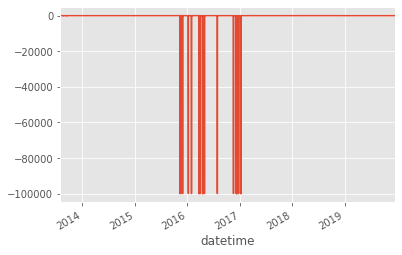

In [26]:
_ = w_df.snow_depth_cm.plot()

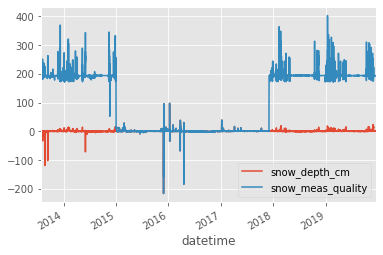

In [27]:
snow_no_null = w_df.snow_depth_cm[w_df.snow_depth_cm != -99999]
qual_no_null = w_df.snow_meas_quality[w_df.snow_depth_cm != -99999]
snow_no_null_df = pd.concat([snow_no_null, qual_no_null], axis=1)
_ = snow_no_null_df.plot()

In [28]:
dates_bad_qual = snow_no_null_df[snow_no_null_df.snow_depth_cm == snow_no_null_df.snow_meas_quality].index
print(f'Dates that Snow Quality == Snow Depth: {min(dates_bad_qual)}, {max(dates_bad_qual)}')

Dates that Snow Quality == Snow Depth: 2015-01-01 01:00:00-07:00, 2017-11-30 23:00:00-07:00


### Extreme values

Looking closer at the the extreme values shows that negative values outside of the accuracy of sensor should be NULL and negative values in this range should be 0. There are also large positive spikes that are clearly measurement error. These spikes seem to shoot above 40cm and this is a good cutoff to interpolate over in order to smooth out the spikes. 

So our conditions for NULL values are:

<table>
    <tr>
        <th>
            NULL if:
        </th>
    </tr>
    <tr>
        <td>
            `Avg Snow Depth [cm]` = -99999 [cm]
        </td>
    </tr>
    <tr>
        <td>
            `Avg Snow Depth [cm]` < -1 [cm]
        </td>
    </tr>
    <tr>
        <td>
            `Avg Snow Depth [cm]` > 40 [cm]
        </td>
    </tr>
</table>

Looking at the graphs, interpolating over the NULL values that we set works well in all but one of the cases we looked at. The last case shows a large change in snow depth but is not captured by our NULL conditions. This can be resolved with setting a *lagged diff limit*. If the difference between a value and the value before it is more than 10cm we should null it to interpolate over these values as well. 

In [29]:
null_cond = ((w_df.snow_depth_cm < -1) | (w_df.snow_depth_cm > 40))
snow_no_null = w_df.snow_depth_cm[~null_cond]

In [30]:
snow_no_null_df[snow_no_null_df.snow_depth_cm < -10]

,snow_depth_cm,snow_meas_quality
datetime,,
2013-08-06 09:00:00-07:00,-20.0224,210.9200
2013-08-07 14:00:00-07:00,-15.3585,251.3050
2013-08-08 14:00:00-07:00,-33.1453,221.5067
2013-08-08 15:00:00-07:00,-21.8909,206.2700
2013-08-22 16:00:00-07:00,-26.4452,196.2050
2013-08-22 22:00:00-07:00,-10.5054,192.2900
2013-08-23 00:00:00-07:00,-67.5473,211.2167
2013-08-23 01:00:00-07:00,-106.4543,197.1067
2013-08-23 06:00:00-07:00,-11.7946,192.5050


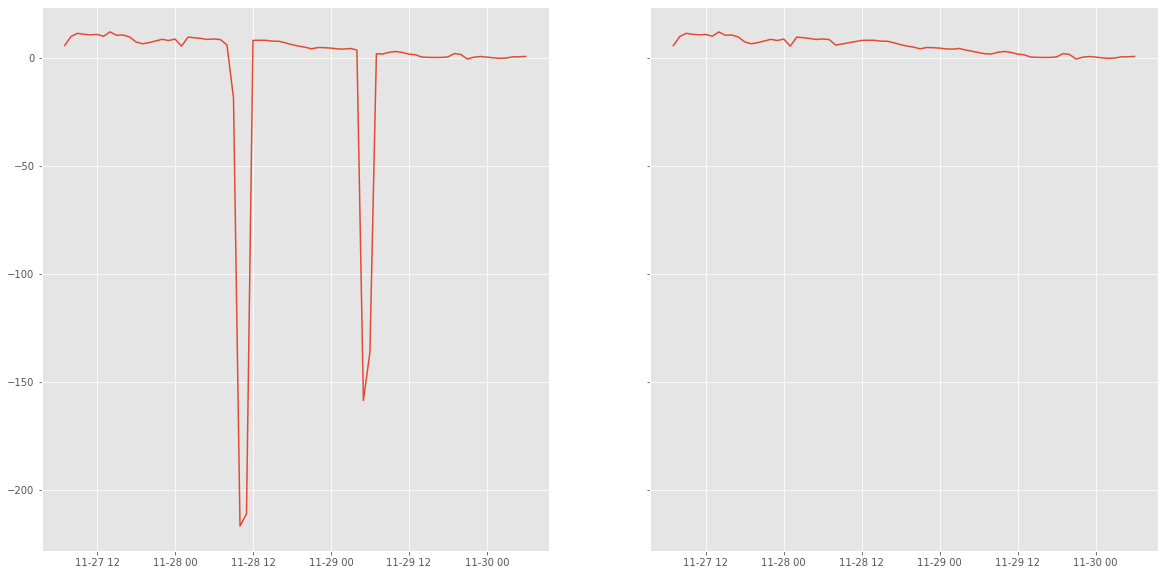

In [31]:
dates = slice('2015-11-27','2015-11-29')

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].plot(snow_no_null_df.snow_depth_cm[dates])
ax[1].plot(snow_no_null[dates])

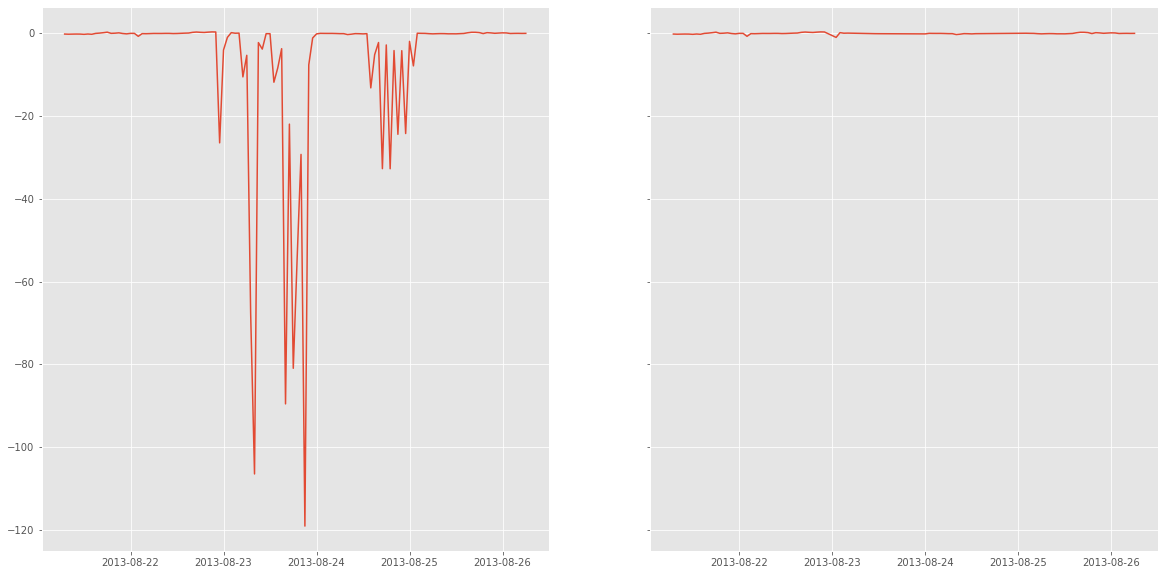

In [32]:
dates = slice('2013-08-21','2013-08-25')

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].plot(snow_no_null_df.snow_depth_cm[dates])
ax[1].plot(snow_no_null[dates])

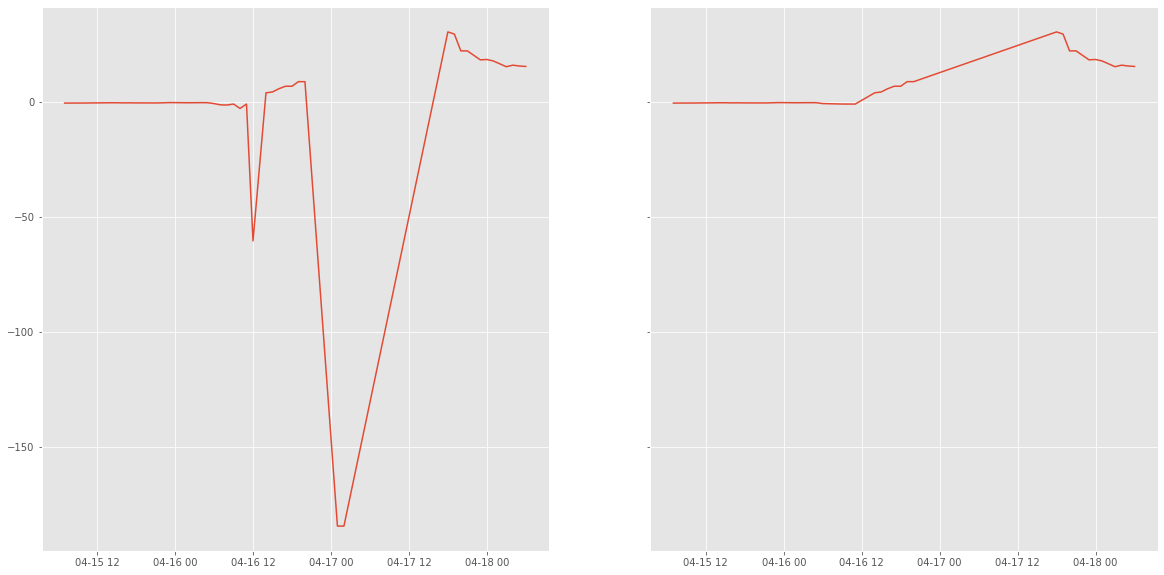

In [33]:
dates = slice('2016-04-15','2016-04-17')

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].plot(snow_no_null_df.snow_depth_cm[dates])
ax[1].plot(snow_no_null[dates])

In [34]:
snow_no_null[(snow_no_null > 30)]

datetime
2016-03-24 02:00:00-07:00    38.6175
2016-03-24 03:00:00-07:00    38.4878
2016-03-24 04:00:00-07:00    37.9440
2016-03-24 05:00:00-07:00    37.6162
2016-03-24 06:00:00-07:00    37.1258
2016-03-24 07:00:00-07:00    35.1144
2016-03-24 11:00:00-07:00    33.0092
2016-03-24 12:00:00-07:00    31.4023
2016-03-24 13:00:00-07:00    32.4632
2016-03-24 14:00:00-07:00    31.6622
2016-03-24 15:00:00-07:00    30.7713
2016-03-24 16:00:00-07:00    30.0653
2016-04-17 11:00:00-07:00    30.6779
2017-01-06 13:00:00-07:00    39.4800
2017-01-06 14:00:00-07:00    38.1615
Name: snow_depth_cm, dtype: float64

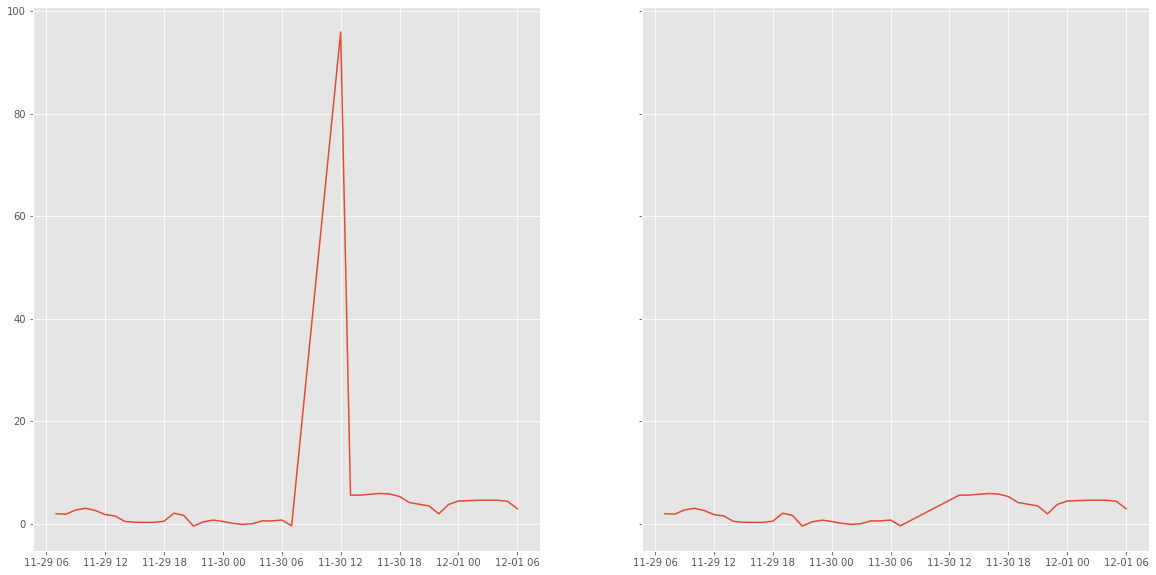

In [35]:
dates = slice('2015-11-29','2015-11-30')

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].plot(snow_no_null_df.snow_depth_cm[dates])
ax[1].plot(snow_no_null[dates])

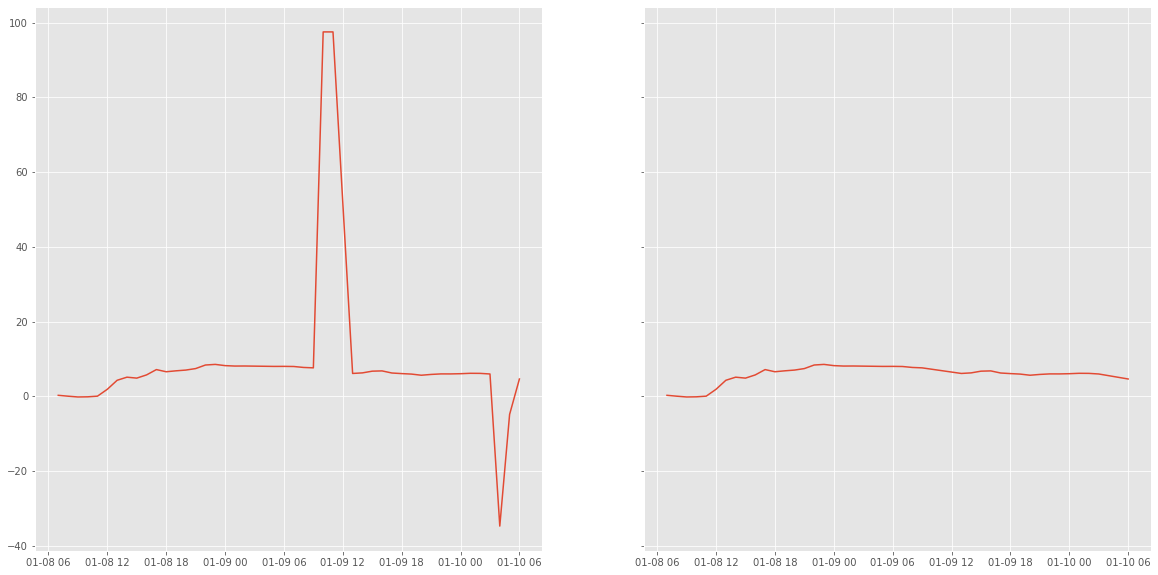

In [36]:
dates = slice('2016-01-08','2016-01-09')

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].plot(snow_no_null_df.snow_depth_cm[dates])
ax[1].plot(snow_no_null[dates])

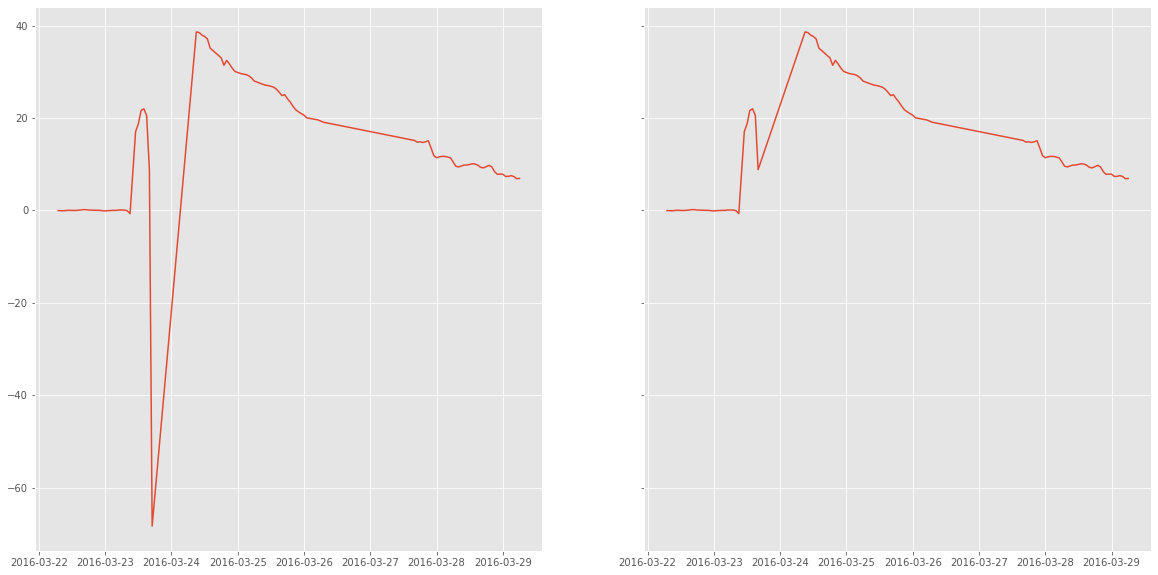

In [37]:
dates = slice('2016-03-22','2016-03-28')

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].plot(snow_no_null_df.snow_depth_cm[dates])
ax[1].plot(snow_no_null[dates])

In [38]:
w_df = w_df.sort_values('datetime')

In [39]:
w_df['difference'] = w_df.snow_depth_cm.diff()

In [40]:
diff_null_cond = abs(w_df.difference) > 10
diff_dates = np.unique(w_df[diff_null_cond].index.date)
snow_no_null_diffs = w_df.snow_depth_cm[~diff_null_cond & ~null_cond]

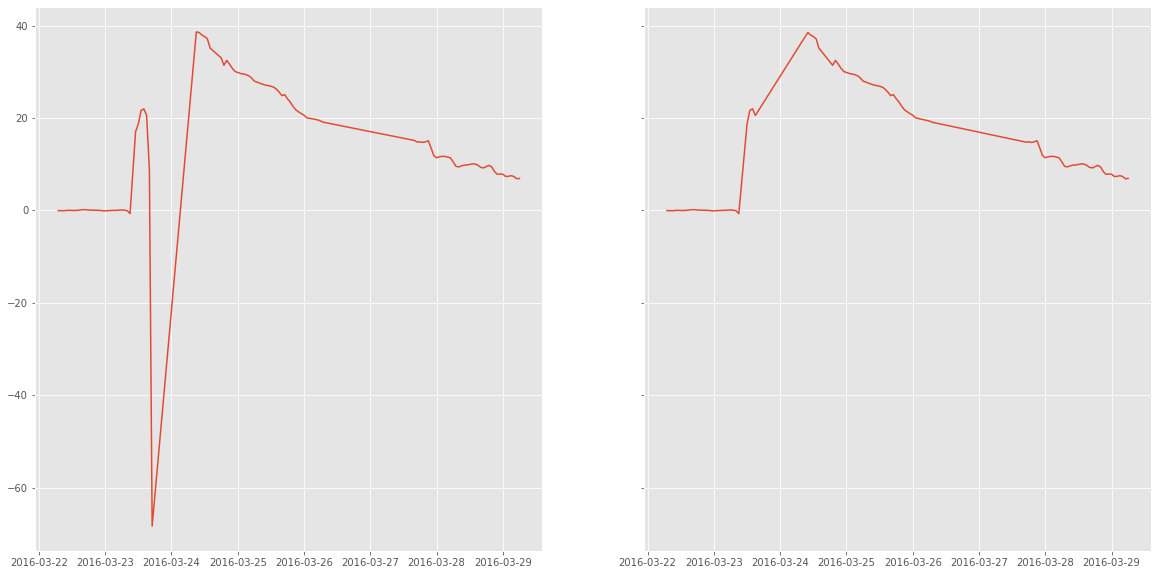

In [41]:
dates = slice('2016-03-22','2016-03-28')

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].plot(snow_no_null_df.snow_depth_cm[dates])
ax[1].plot(snow_no_null_diffs[dates])

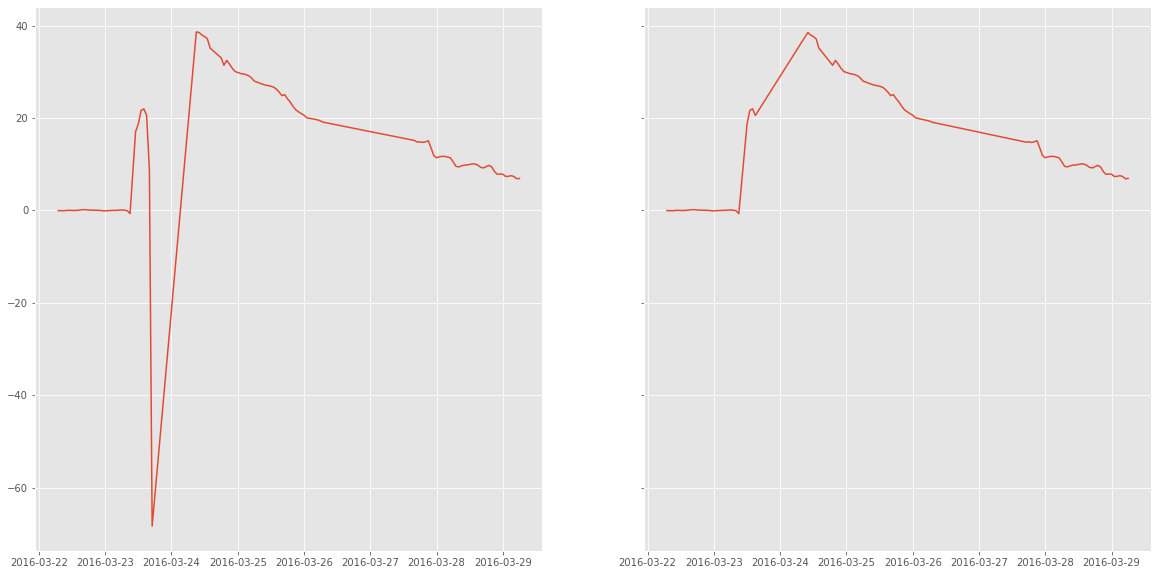

In [42]:
dates = slice('2016-03-22','2016-03-28')

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].plot(snow_no_null_df.snow_depth_cm[dates])
ax[1].plot(snow_no_null_diffs[dates])

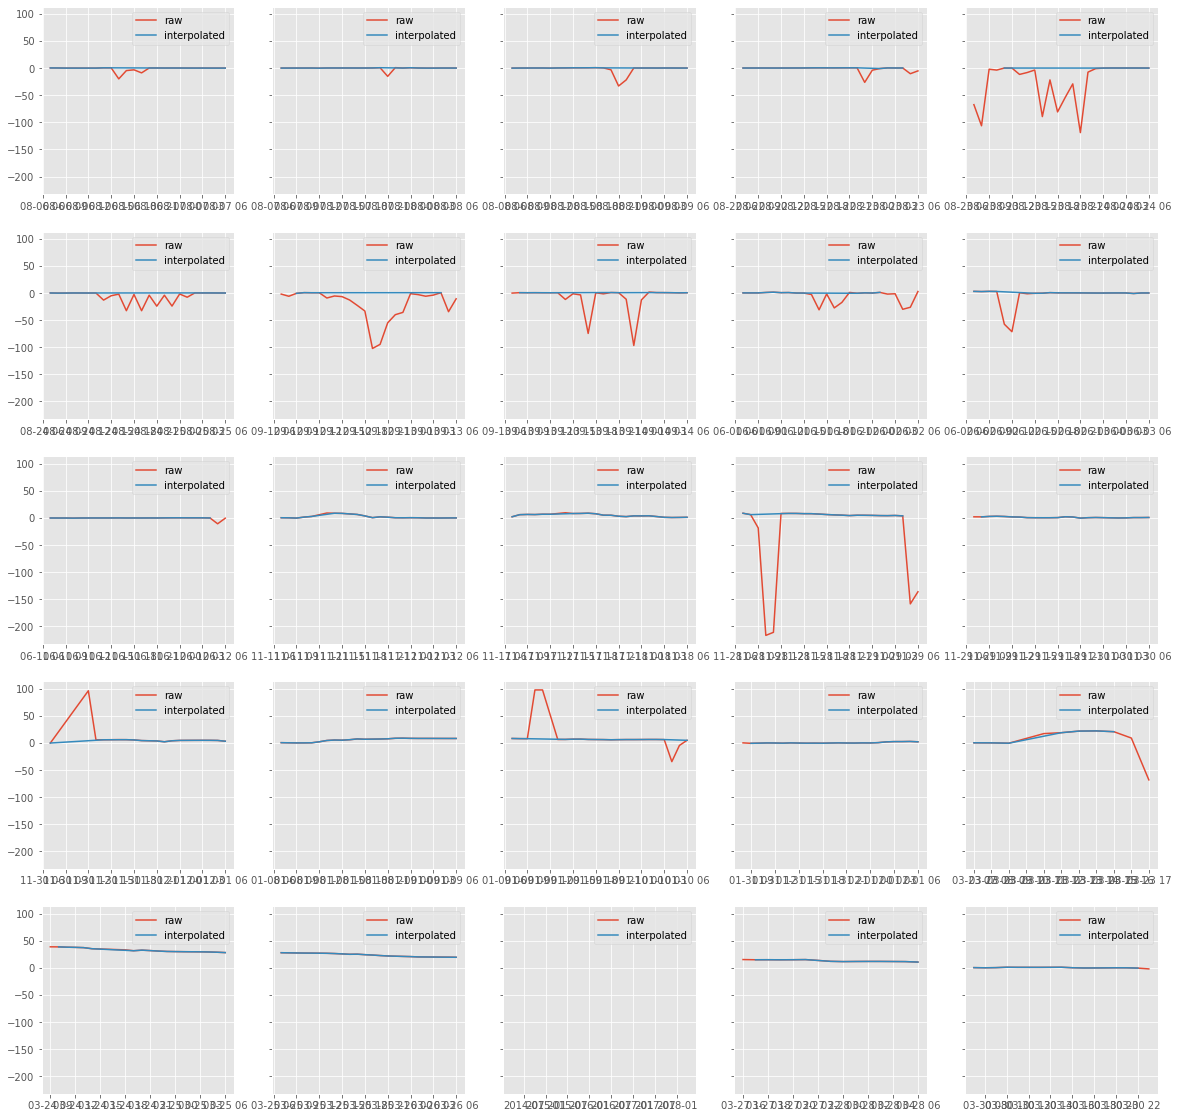

In [43]:
fig, axes = plt.subplots(5, 5, sharey=True, figsize=(20, 20))

for dates, ax in zip(diff_dates, axes.flatten()):
    dates = str(dates)
    ax.plot(snow_no_null_df.snow_depth_cm[dates], label='raw')
    ax.plot(snow_no_null_diffs[dates], label='interpolated')
    ax.legend()

## Final NULL conditions for `Avg Snow Depth [cm]`

<table>
    <tr>
        <th>
            NULL if:
        </th>
    </tr>
    <tr>
        <td>
            `Avg Snow Depth [cm]` = -99999 [cm]
        </td>
    </tr>
    <tr>
        <td>
            `Avg Snow Depth [cm]` < -1 [cm]
        </td>
    </tr>
    <tr>
        <td>
            `Avg Snow Depth [cm]` > 40 [cm]
        </td>
    </tr>
    <tr>
        <td>
            ABS(DIFF(`Avg Snow Depth [cm]`)) > 10 [cm]
        </td>
    </tr>
</table>

In [44]:
(w_df['snow_depth_in'] * 2.54).describe()

count    55923.000000
mean         0.784589
std          2.870244
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         39.480000
Name: snow_depth_in, dtype: float64

In [45]:
pd.DataFrame(snow_no_null_diffs).describe()

,snow_depth_cm
count,53568.000000
mean,0.733739
std,2.650692
min,-1.000000
25%,-0.193600
50%,0.061150
75%,0.365625
max,38.487800


In [46]:
w_df[['snow_depth_cm', 'snow_depth_in']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55934 entries, 2013-07-31 00:00:00-07:00 to 2019-12-17 23:00:00-07:00
Data columns (total 2 columns):
snow_depth_cm    55934 non-null float64
snow_depth_in    55923 non-null float64
dtypes: float64(2)
memory usage: 1.3 MB


In [47]:
pd.DataFrame(snow_no_null_diffs).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53568 entries, 2013-07-31 00:00:00-07:00 to 2019-12-17 23:00:00-07:00
Data columns (total 1 columns):
snow_depth_cm    53568 non-null float64
dtypes: float64(1)
memory usage: 3.3 MB


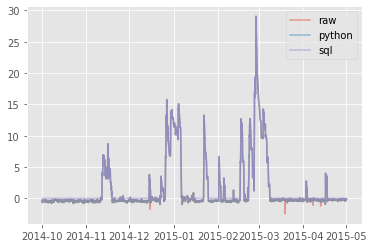

In [48]:
dates = slice('2014-10-01', '2015-04-30')

fig, ax = plt.subplots()

ax.plot(w_df[dates].snow_depth_cm[w_df[dates].snow_depth_cm != -99999], label='raw', alpha = 0.5)
ax.plot(snow_no_null_diffs[dates], label='python', alpha = 0.5)
ax.plot(w_df[dates].snow_depth_in * 2.54, label='sql', alpha = 0.5)
ax.legend()

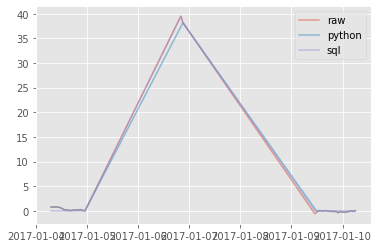

In [49]:
dates = slice('2017-01-04', '2017-01-09')

fig, ax = plt.subplots()

ax.plot(w_df[dates].snow_depth_cm[w_df[dates].snow_depth_cm != -99999], label='raw', alpha = 0.5)
ax.plot(snow_no_null_diffs[dates], label='python', alpha = 0.5)
ax.plot(w_df[dates].snow_depth_in * 2.54, label='sql', alpha = 0.5)
ax.legend()

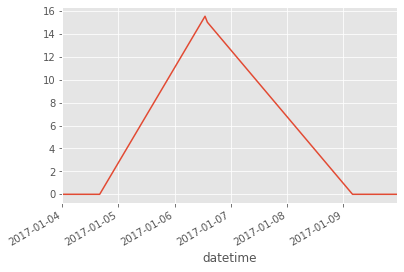

In [50]:
w_df[dates].snow_depth_in.plot()

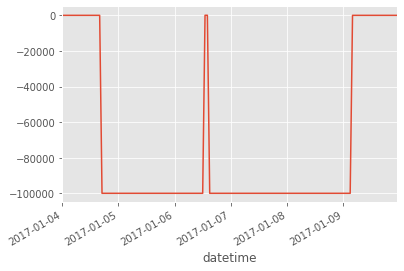

In [51]:
w_df[dates].snow_depth_cm.plot()

Explanation of strange looking spike [January 2017 snowstorm](https://www.thedenverchannel.com/weather/how-much-snow-did-we-get-for-the-january-4-5-2017-storm)